# Jonathan Halverson
# Friday, February 9, 2018
# Dating Recommender in Spark 2

This code uses alternating least squares to make recommendations for individuals on a dating site. The data is the user id, profile id and rating. We also have gender information that we use at the end.

In [1]:
from __future__ import print_function

import sys
import random
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [3]:
APP_NAME = "Dating Recommender"
spark = SparkSession.builder.appName(APP_NAME).config("spark.driver.host", "localhost").getOrCreate()
print("Spark version: %s" % spark.version)

Spark version: 2.2.1


Let's look at the data files:

In [4]:
ratings_raw = spark.read.csv('ratings.dat', inferSchema=True)
ratings_raw = ratings_raw.withColumnRenamed('_c0', 'user_id')\
                         .withColumnRenamed('_c1', 'profile_id')\
                         .withColumnRenamed('_c2', 'stars')
ratings = ratings_raw.withColumn('stars', ratings_raw['stars'].cast('double'))
ratings.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- profile_id: integer (nullable = true)
 |-- stars: double (nullable = true)



In [5]:
#ratings = ratings.sample(False, fraction=0.1)

In [6]:
ratings.count(), ratings.distinct().count()

(1084959, 1084959)

In [7]:
ratings.show(5)

+-------+----------+-----+
|user_id|profile_id|stars|
+-------+----------+-----+
|      1|      8305| 10.0|
|      1|     15530|  6.0|
|      1|     22319| 10.0|
|      1|     32136|  9.0|
|      1|     38868|  7.0|
+-------+----------+-----+
only showing top 5 rows



In [8]:
ratings.filter("stars is null or user_id is null").count()

0

In [9]:
ratings.filter(ratings.stars.isNull()).count()

0

In [10]:
ratings.describe().show()

+-------+-----------------+-----------------+------------------+
|summary|          user_id|       profile_id|             stars|
+-------+-----------------+-----------------+------------------+
|  count|          1084959|          1084959|           1084959|
|   mean|67872.97318331845|101357.1026490402| 5.938874187872537|
| stddev|38762.11893306934|62182.40771188681|3.1116234963652234|
|    min|                1|                1|               1.0|
|    max|           135359|           220970|              10.0|
+-------+-----------------+-----------------+------------------+



In [11]:
ratings.select('user_id').distinct().count()

135359

In [12]:
ratings.select(ratings.profile_id).distinct().count()

98623

Let's check our results by going to Pandas (for big data this will not be possible):

In [13]:
ratings.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1084959 entries, 0 to 1084958
Data columns (total 3 columns):
user_id       1084959 non-null int64
profile_id    1084959 non-null int64
stars         1084959 non-null float64
dtypes: float64(1), int64(2)
memory usage: 24.8 MB


What is the minimum number of ratings by a user?

In [14]:
ratings_counts_by_user = ratings.groupBy(ratings_raw.user_id).count()
ratings_counts_by_user = ratings_counts_by_user.withColumnRenamed('count', 'count1')

In [15]:
ratings_counts_by_user.sort('count1').show(5)

+-------+------+
|user_id|count1|
+-------+------+
|   9867|     1|
|  16800|     1|
|  12723|     1|
|   1005|     1|
|  12757|     1|
+-------+------+
only showing top 5 rows



In [16]:
ratings_counts_by_user.groupBy('count1').count().sort('count1').show(5)

+------+-----+
|count1|count|
+------+-----+
|     1|18661|
|     2|25869|
|     3|12926|
|     4| 9655|
|     5|10697|
+------+-----+
only showing top 5 rows



We see that 18661 users have only rated 1 profile.

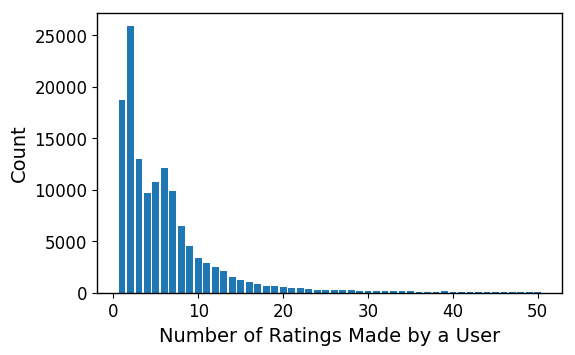

In [17]:
hf = ratings_counts_by_user.groupBy('count1').count().sort('count1').toPandas()
plt.bar(left=hf.count1.values[:50], height=hf['count'].values[:50])
plt.xlabel('Number of Ratings Made by a User')
plt.ylabel('Count')

The histogram above shows that there are many users that do not have 20 or more ratings despite what is stated in the book.

In [18]:
from pyspark.sql import functions as F

rating_counts = ratings.groupBy('user_id').agg(F.count('*').alias('count'))
rating_counts.sort('count', ascending=True).show(n=5)

+-------+-----+
|user_id|count|
+-------+-----+
|   6482|    1|
|  13875|    1|
|   7281|    1|
|   1339|    1|
|   7879|    1|
+-------+-----+
only showing top 5 rows



Let's check to see if the same user made multiple ratings for the same profile:

In [19]:
ratings.select('user_id', 'profile_id').dropDuplicates().count() != ratings.count()

False

### Gender data

In [20]:
gender = spark.read.csv('gender.dat', inferSchema=True)
gender = gender.withColumnRenamed('_c0', 'user_id').withColumnRenamed('_c1', 'gender')
gender.show(3)

+-------+------+
|user_id|gender|
+-------+------+
|      1|     F|
|      2|     F|
|      3|     U|
+-------+------+
only showing top 3 rows



In [21]:
gender.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- gender: string (nullable = true)



In [22]:
gender.describe().show()

+-------+----------------+------+
|summary|         user_id|gender|
+-------+----------------+------+
|  count|          220970|220970|
|   mean|        110485.5|  null|
| stddev|63788.6888288198|  null|
|    min|               1|     F|
|    max|          220970|     U|
+-------+----------------+------+



In [23]:
gender.select(gender.gender).distinct().show()

+------+
|gender|
+------+
|     F|
|     M|
|     U|
+------+



In [24]:
gender.filter(gender.user_id.isNull()).count()

0

In [25]:
gender.filter(gender.gender.isNull()).count()

0

In [26]:
gender.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220970 entries, 0 to 220969
Data columns (total 2 columns):
user_id    220970 non-null int64
gender     220970 non-null object
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


### Create train-test split

Split the ratings data into a training and test set:

In [27]:
training, test = ratings.randomSplit([0.7, 0.3])
training = training.cache()
test = test.cache()

In [28]:
training.intersect(test).count()

0

In [29]:
print('Training: %d' % training.count())
print('Validation: %d' % test.count())

Training: 759713
Validation: 325246


In [30]:
test.show(5)

+-------+----------+-----+
|user_id|profile_id|stars|
+-------+----------+-----+
|      1|     32136|  9.0|
|      1|     48470|  8.0|
|      1|     54481|  3.0|
|      1|     73611| 10.0|
|      1|     83855|  7.0|
+-------+----------+-----+
only showing top 5 rows



### Fit model and make predictions

In [31]:
# cold start parameter is for handling user/item ids the model 
# has not seen in the training data
als = ALS(rank=25, maxIter=10, userCol="user_id", itemCol="profile_id",
          ratingCol="stars", regParam=1.0, coldStartStrategy="drop")
model = als.fit(training)

In [32]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")
rmse = evaluator.evaluate(model.transform(training))
print("Root-mean-square error (train) = " + str(rmse))

Root-mean-square error (train) = 1.73812314421


In [33]:
predictions = model.transform(test)
predictions.describe(['stars', 'prediction']).show()

+-------+-----------------+------------------+
|summary|            stars|        prediction|
+-------+-----------------+------------------+
|  count|           302828|            302828|
|   mean|5.947894514377799| 4.748041585460299|
| stddev|3.104069364213004|2.2543092185523914|
|    min|              1.0|        -3.7730815|
|    max|             10.0|         14.747769|
+-------+-----------------+------------------+



In [34]:
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error (test) = " + str(rmse))

Root-mean-square error (test) = 2.5449470429


### Make specific recommendations

Let's find the top 10 female matches for a random male:

In [35]:
matchseekerID = ratings.groupBy('user_id').count().filter('count > 50').first()[0]

In [36]:
gender.filter(gender.user_id == matchseekerID).show()

+-------+------+
|user_id|gender|
+-------+------+
|  11858|     M|
+-------+------+



In [37]:
from pyspark.sql.functions import lit

my_pred = gender.filter(gender.gender == 'F').withColumn('user_id__', lit(matchseekerID))\
                                             .withColumnRenamed('user_id', 'profile_id')\
                                             .withColumnRenamed('user_id__', 'user_id')
my_pred.show(5)

+----------+------+-------+
|profile_id|gender|user_id|
+----------+------+-------+
|         1|     F|  11858|
|         2|     F|  11858|
|         4|     F|  11858|
|         5|     F|  11858|
|         6|     F|  11858|
+----------+------+-------+
only showing top 5 rows



In [38]:
predictions_matchseekerID = model.transform(my_pred)
predictions_matchseekerID.sort('prediction', ascending=False).show(10)

+----------+------+-------+----------+
|profile_id|gender|user_id|prediction|
+----------+------+-------+----------+
|    121050|     F|  11858| 10.710513|
|    125609|     F|  11858| 10.282748|
|    125281|     F|  11858| 10.251322|
|     87892|     F|  11858| 10.165944|
|    112034|     F|  11858| 10.149731|
|     66863|     F|  11858| 10.122427|
|      2986|     F|  11858| 10.102703|
|    119748|     F|  11858| 10.032566|
|    125027|     F|  11858| 10.032566|
|     46615|     F|  11858|  9.991462|
+----------+------+-------+----------+
only showing top 10 rows

